In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pycbc.frame
import pylab

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
# # Download the challenge set files
# from six.moves.urllib import request

# def get_file(fname):
#     url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
#     url = url.format(fname)
#     request.urlretrieve(url, fname)
#     print('Getting : {}'.format(url))

# files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf',
#          'PyCBC_T2_3.gwf', 'PyCBC_T2_4.gwf']

# for fname in files:
#     get_file(fname)

# PyCBC_T2_0.gwf

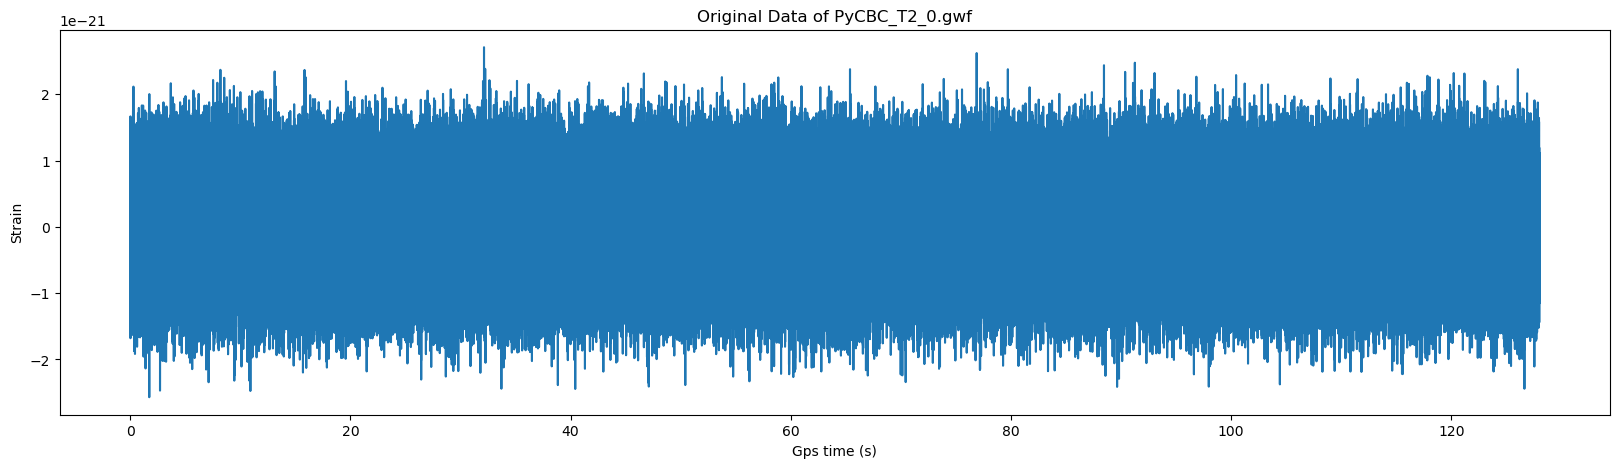

In [4]:
# Reading the strain data
file_name = "PyCBC_T2_0.gwf"
channel_name = "H1:TEST-STRAIN"

gps_start_time = 0
gps_end_time = 128

pycbc_t2_0 = pycbc.frame.read_frame(file_name, channel_name, gps_start_time, gps_end_time)

pylab.figure(figsize = (20, 5))
pylab.plot(pycbc_t2_0.sample_times, pycbc_t2_0)

pylab.title("Original Data of {}".format(file_name))
pylab.xlabel("Gps time (s)")
pylab.ylabel("Strain")

pylab.show()

## Looking for a specific signal in the data

### Preconditioning the data

Original delta_t: 0.000244140625 and Original delta_f: 0.0078125
After resampling: delta_t: 0.00048828125 and After resampling: delta_f: 0.0078125


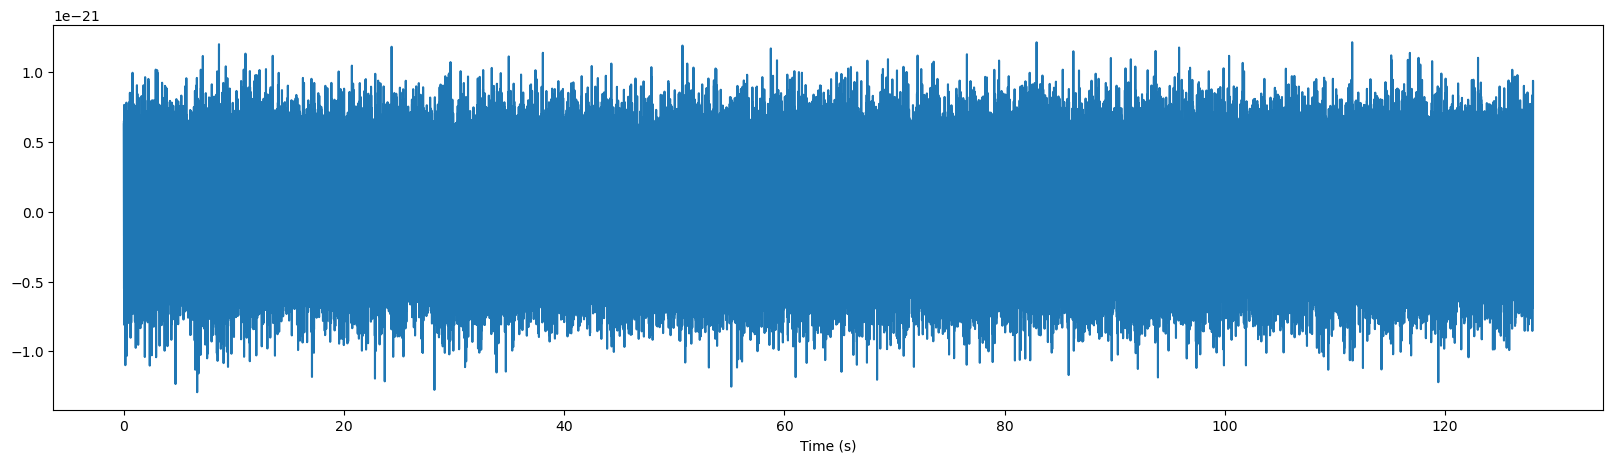

In [5]:
from pycbc.filter import resample_to_delta_t, highpass

print("Original delta_t: {} and Original delta_f: {}".format(pycbc_t2_0.delta_t, pycbc_t2_0.delta_f))
strain = resample_to_delta_t(highpass(pycbc_t2_0, 13), 1.0/2048)
print("After resampling: delta_t: {} and After resampling: delta_f: {}".format(strain.delta_t, strain.delta_f))

pylab.figure(figsize = (20, 5))

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')

pylab.show()

### Filter Wraparound

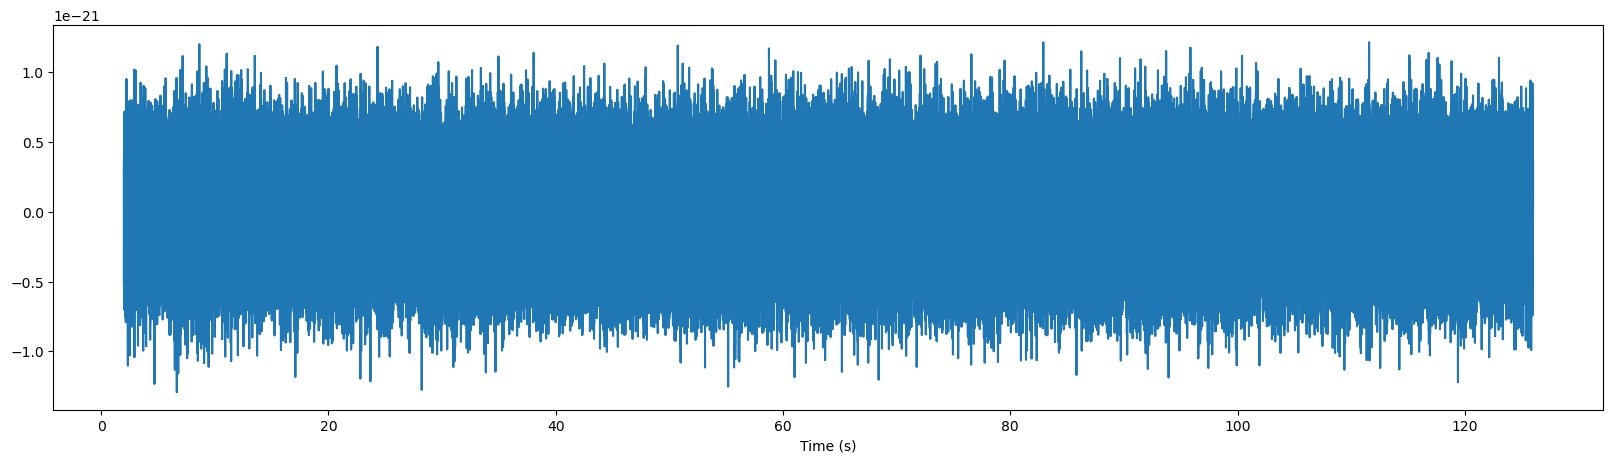

In [6]:
conditioned = strain.crop(2, 2)

pylab.figure(figsize = (20, 5))
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

### Calculating the power spectral density

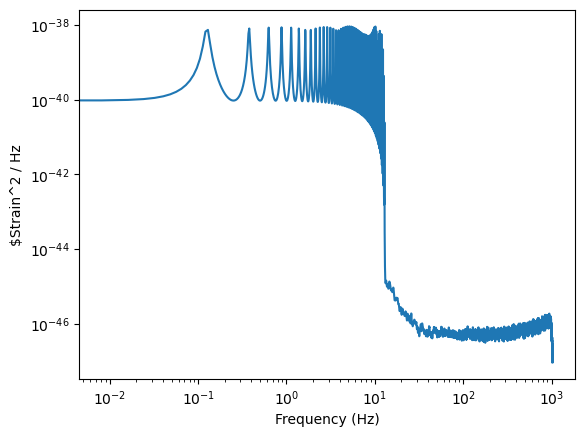

In [7]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

# Estimating the power spectral density
psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4*conditioned.sample_rate), low_frequency_cutoff = 13)

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel('$Strain^2 / Hz')
pylab.xlabel('Frequency (Hz)')

pylab.show()

### Make your signal model

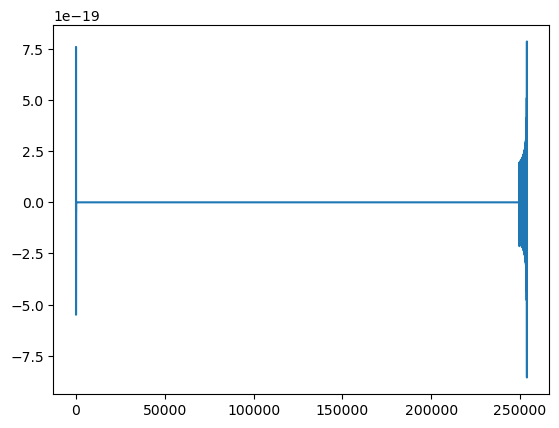

In [8]:
from pycbc.waveform import get_td_waveform
m = 36

hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m, mass2 = m, delta_t = conditioned.delta_t, f_lower = 13)

hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)

pylab.show()

### Calculating the Noise-to-Signal ratio

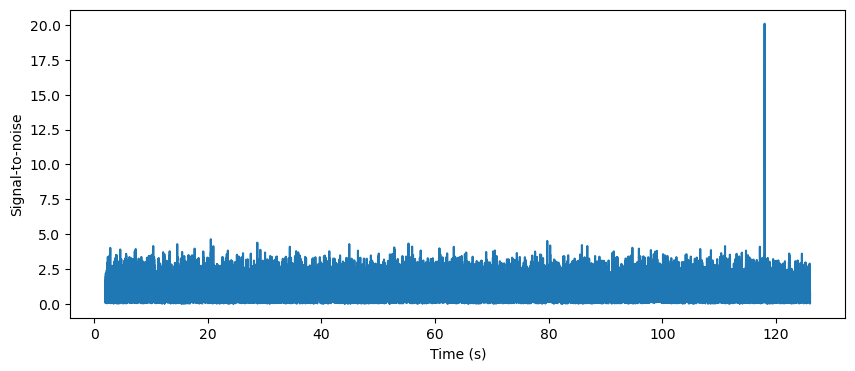

We found a signal at 117.99658203125s with SNR 20.1004066155671


In [9]:
from pycbc.filter import matched_filter
import numpy as np

snr = matched_filter(template, conditioned, psd = psd, low_frequency_cutoff = 13)
# snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Aligning and Subtracting the Proposed Signal

**We can use this SNR peak to align our proposal to the data, and to also subtract our proposal from the data.**

In [10]:
from pycbc.filter import sigma

dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd = psd, low_frequency_cutoff = 13)

aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

### Visualize the overlap between the signal and data

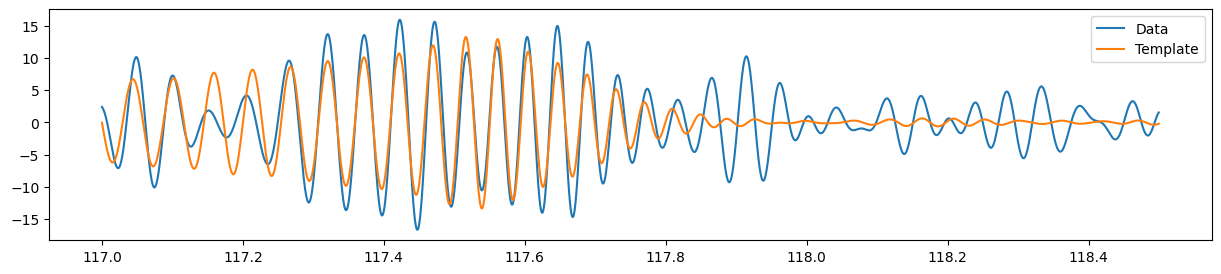

In [11]:
white_data = (conditioned.to_frequencyseries() / psd ** 0.5).to_timeseries()

tapered = aligned.highpass_fir(13, 512, remove_corrupted = False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(13., 512).lowpass_fir(25, 512)
white_template = white_template.highpass_fir(13, 512).lowpass_fir(25, 512)

# Select the time around the merger
white_data = white_data.time_slice(117, 118.5)
white_template = white_template.time_slice(117, 118.5)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

### Subtracting the Signal from the data

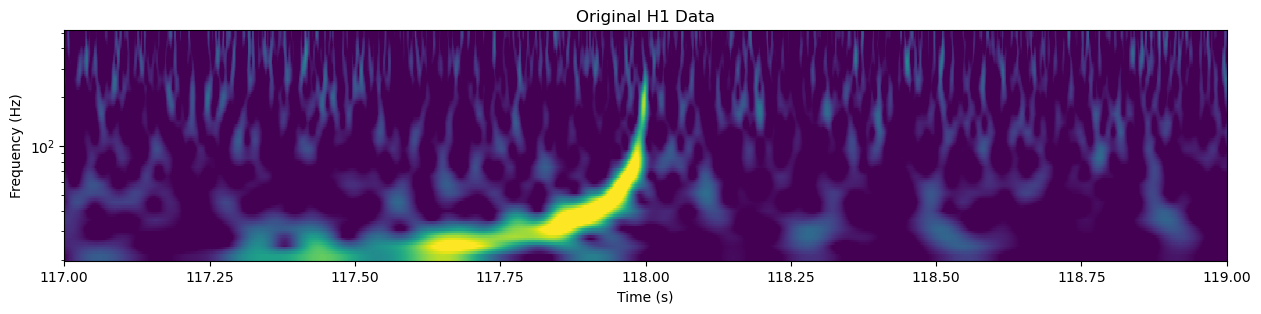

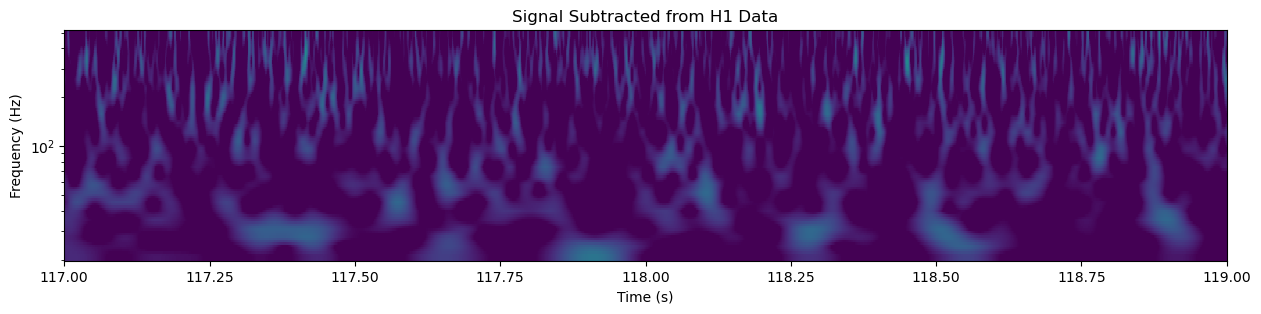

In [12]:
subtracted = conditioned - aligned

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(117, 119)
    pylab.show()